In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time
import psutil

import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.sparse import csc_matrix
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import pcms.haar
import pcms.tree
import utils

In [3]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

### Random topology CDF

#### Evaluate at a single point

In [4]:
n_leaves = 7000
f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g
y = 0.01

In [5]:
start = time.time()
cdf_val_cbst = pcms.haar.cdf_proj_cbst(y, func, eps=0.01, delta=0.01, batch_size=100)
print("Elapsed time: ", time.time() - start)

Elapsed time:  28.916353702545166


In [6]:
print(cdf_val_cbst)

1.0


#### Estimate time complexity

In [7]:
process = psutil.Process()

sizes = np.logspace(1, 5, num=15, dtype=int)
times = []
memories = []

for n_leaves in sizes:
    f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    func = f - g
    y = 0.01

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.01, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times.append(elapsed)
    memories.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_leaves = {n_leaves:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_leaves =      10 | time = 0.16427 sec | memory change = -0.01 MB
n_leaves =      19 | time = 0.16790 sec | memory change = 0.00 MB
n_leaves =      37 | time = 0.16396 sec | memory change = 0.00 MB
n_leaves =      71 | time = 0.27473 sec | memory change = 0.02 MB
n_leaves =     138 | time = 0.59397 sec | memory change = -0.01 MB
n_leaves =     268 | time = 1.01786 sec | memory change = 0.01 MB
n_leaves =     517 | time = 1.93967 sec | memory change = 0.00 MB
n_leaves =    1000 | time = 3.65952 sec | memory change = 0.00 MB
n_leaves =    1930 | time = 7.25458 sec | memory change = 19.21 MB
n_leaves =    3727 | time = 14.56065 sec | memory change = 153.22 MB
n_leaves =    7196 | time = 28.86398 sec | memory change = 279.11 MB
n_leaves =   13894 | time = 56.38219 sec | memory change = 368.54 MB
n_leaves =   26826 | time = 108.46744 sec | memory change = 254.26 MB
n_leaves =   51794 | time = 214.74176 sec | memory change = -146.15 MB
n_leaves =  100000 | time = 430.22772 sec | memory chan

Approximate empirical time complexity: O(n^1.00)


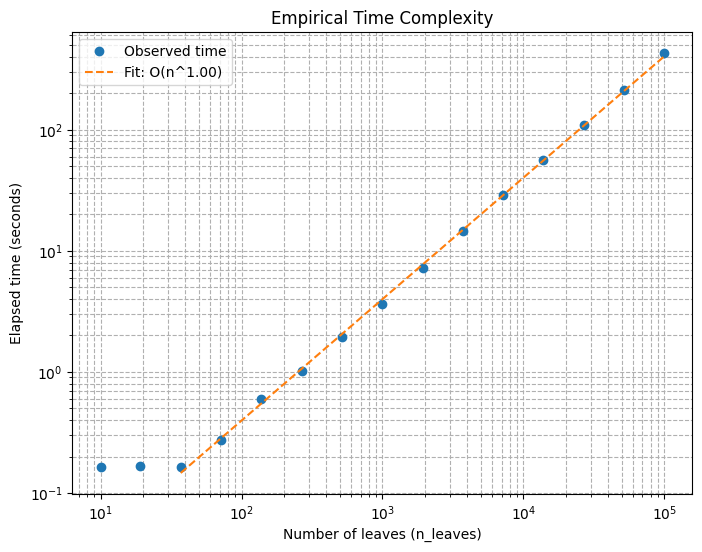

In [12]:
log_sizes = np.log10(sizes)

burn_in = 2

# Time complexity fit (burn-in)
log_times = np.log10(times)
slope_time, intercept_time, _, _, _ = linregress(log_sizes[burn_in:], log_times[burn_in:])
print(f"Approximate empirical time complexity: O(n^{slope_time:.2f})")

fit_times = 10**(intercept_time + slope_time * log_sizes[burn_in:])

# Plot: Time only
plt.figure(figsize=(8, 6))
plt.loglog(sizes, times, 'o', label='Observed time')
plt.loglog(sizes[burn_in:], fit_times, '--', label=f'Fit: O(n^{slope_time:.2f})')

plt.xlabel("Number of leaves (n_leaves)")
plt.ylabel("Elapsed time (seconds)")
plt.title("Empirical Time Complexity")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

#### Evaluate at multiple points

In [ ]:
quant50_cbst = root_scalar(lambda x: pcms.haar.cdf_proj_cbst(x, func) - 0.5, bracket=(-0.1,0.1), method='bisect', xtol=0.0001)
quant80_cbst = root_scalar(lambda x: pcms.haar.cdf_proj_cbst(x, func) - 0.8, bracket=(-0.1,0.1), method='bisect', xtol=0.0001)
quant90_cbst = root_scalar(lambda x: pcms.haar.cdf_proj_cbst(x, func) - 0.9, bracket=(-0.1,0.1), method='bisect', xtol=0.0001)
quant95_cbst = root_scalar(lambda x: pcms.haar.cdf_proj_cbst(x, func) - 0.95, bracket=(-0.1,0.1), method='bisect', xtol=0.0001)

SyntaxError: invalid syntax (1461904588.py, line 2)

In [ ]:
print(quant50_cbst.root, quant80_cbst.root, quant90_cbst.root, quant95_cbst.root)

-9.1552734375e-05 0.001190185546875 0.002288818359375 0.003753662109375


In [ ]:
n_points = 1000
ys_cbst = np.linspace(-0.01, 0.01, n_points)

In [ ]:
cdf_vals_cbst = pcms.haar.cdf_proj_cbst(ys_cbst, func)

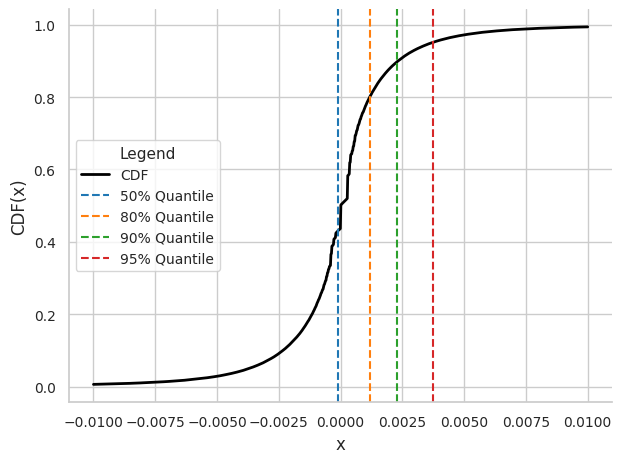

In [ ]:
sns.set_theme(style="whitegrid")

# Create high-DPI figure for sharpness
fig, ax = plt.subplots()

# Plot CDF
ax.plot(ys_cbst, cdf_vals_cbst, label='CDF', color='black', linewidth=2)

# Vertical quantile lines
ax.axvline(quant50_cbst.root, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_cbst.root, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_cbst.root, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_cbst.root, linestyle='--', color='#d62728', label='95% Quantile')

# Labels and title
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

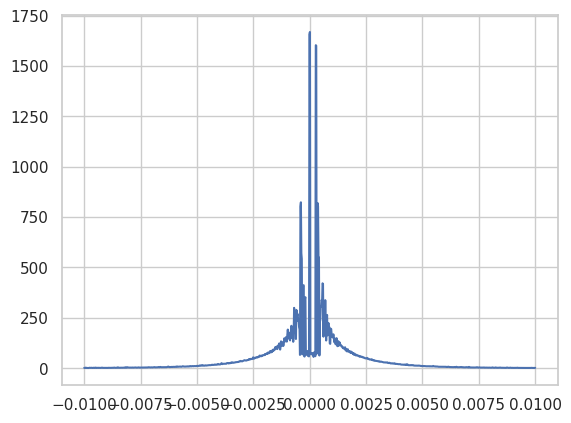

In [ ]:
grad_cbst = np.gradient(cdf_vals_cbst, ys_cbst)

plt.plot(ys_cbst, grad_cbst)
plt.show()

### Difference of Dirichlets CDF

#### Evaluate at a single point

In [ ]:
n_leaves = 100
tree = pcms.tree.cbst(n_leaves=n_leaves)
y = 0.04
eps = 0.01
delta = 0.01

In [ ]:
node = np.random.choice(tree.find_interior_nodes())

In [ ]:
cdf_val_dod = pcms.haar.cdf_proj_dirichlet_diff(y, tree, node=node)

In [ ]:
print(cdf_val_dod)

0.9992698281135911


#### Evaluate at multiple points

In [ ]:
quant50_dod = root_scalar(lambda x: pcms.haar.cdf_proj_dirichlet_diff(x, tree, node=node) - 0.5, bracket=(-1,1), method='bisect', xtol=1e-8)
quant80_dod = root_scalar(lambda x: pcms.haar.cdf_proj_dirichlet_diff(x, tree, node=node) - 0.8, bracket=(-1,1), method='bisect', xtol=1e-8)
quant90_dod = root_scalar(lambda x: pcms.haar.cdf_proj_dirichlet_diff(x, tree, node=node) - 0.9, bracket=(-1,1), method='bisect', xtol=1e-8)
quant95_dod = root_scalar(lambda x: pcms.haar.cdf_proj_dirichlet_diff(x, tree, node=node) - 0.95, bracket=(-1,1), method='bisect', xtol=1e-8)

In [ ]:
print(quant50_dod.root, quant80_dod.root, quant90_dod.root, quant95_dod.root)

-1.154094934463501e-05 0.007357291877269745 0.011949412524700165 0.016319788992404938


In [ ]:
n_points = 1000
ys_dod = np.linspace(-0.05, 0.05, n_points)

In [ ]:
cdf_vals_dod = pcms.haar.cdf_proj_dirichlet_diff(ys_dod, tree, node=node)

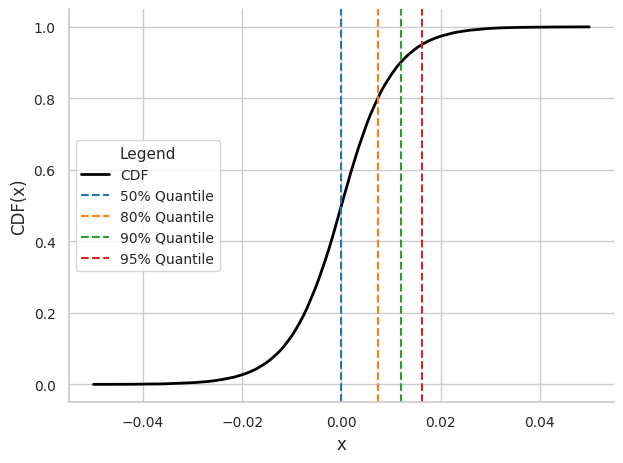

In [ ]:
sns.set_theme(style="whitegrid")

# Create high-DPI figure for sharpness
fig, ax = plt.subplots()

# Plot CDF
ax.plot(ys_dod, cdf_vals_dod, label='CDF', color='black', linewidth=2)

# Vertical quantile lines
ax.axvline(quant50_dod.root, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_dod.root, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_dod.root, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_dod.root, linestyle='--', color='#d62728', label='95% Quantile')

# Labels and title
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

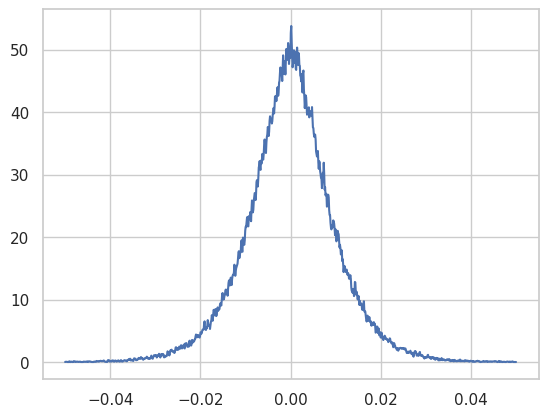

In [ ]:
grad_dod = np.gradient(cdf_vals_dod, ys_dod)

plt.plot(ys_dod, grad_dod)
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [ ]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

### Load Guerrero Negro dataset

In [ ]:
gn_table_filepath = os.path.join(GN_DATA, '454/47908_otu_table.tsv')
table_df = utils.load_gn_seq_id_abundances(gn_table_filepath)

In [ ]:
# Convert counts to proportions
cols = table_df.columns[1:]
table_df[cols] = table_df[cols].div(table_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[table_df['OTU ID']].values
table_df.loc[:, 'Leaf Index'] = leaf_idxs
table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [ ]:
print(table_df)

       OTU ID  1200.GN01P  1200.GN01P.o  1200.GN02P  1200.GN02P.o  1200.GN03P  \
0     2773512    0.000000           0.0    0.000000      0.000602    0.000000   
1     4361967    0.000000           0.0    0.000000      0.000602    0.000000   
2     3675511    0.001170           0.0    0.001155      0.000000    0.000696   
3     2877492    0.000000           0.0    0.000578      0.000000    0.001392   
4     4481520    0.000000           0.0    0.000000      0.000000    0.008351   
...       ...         ...           ...         ...           ...         ...   
1700  4331263    0.000000           0.0    0.000000      0.000000    0.000000   
1701   252805    0.000585           0.0    0.001733      0.003008    0.000696   
1702  4453795    0.000000           0.0    0.000000      0.000000    0.001392   
1703  1549742    0.000000           0.0    0.000000      0.000000    0.000000   
1704  1636411    0.000000           0.0    0.000000      0.000000    0.000000   

      1200.GN03P.o  1200.GN

### Compute Haar-like coordinates

In [ ]:
Q, S = pcms.haar.sparsify(tree)

In [ ]:
diff_s = table_df['1200.GN09P.o'] - table_df['1200.GN01P.o']

mask = diff_s != 0

values = diff_s[mask].values
indices = table_df['Leaf Index'][mask].values
indptr = [0, len(values)]

diff = csc_matrix((values, indices, indptr), shape=(n_leaves,1))

In [ ]:
coords = (Q.T @ diff).tocsc()

In [ ]:
dh_coords = coords.data**2 * S.diagonal()[coords.indices]
dh_indices = coords.indices[dh_coords != 0]
dh_coords = dh_coords[dh_coords != 0]

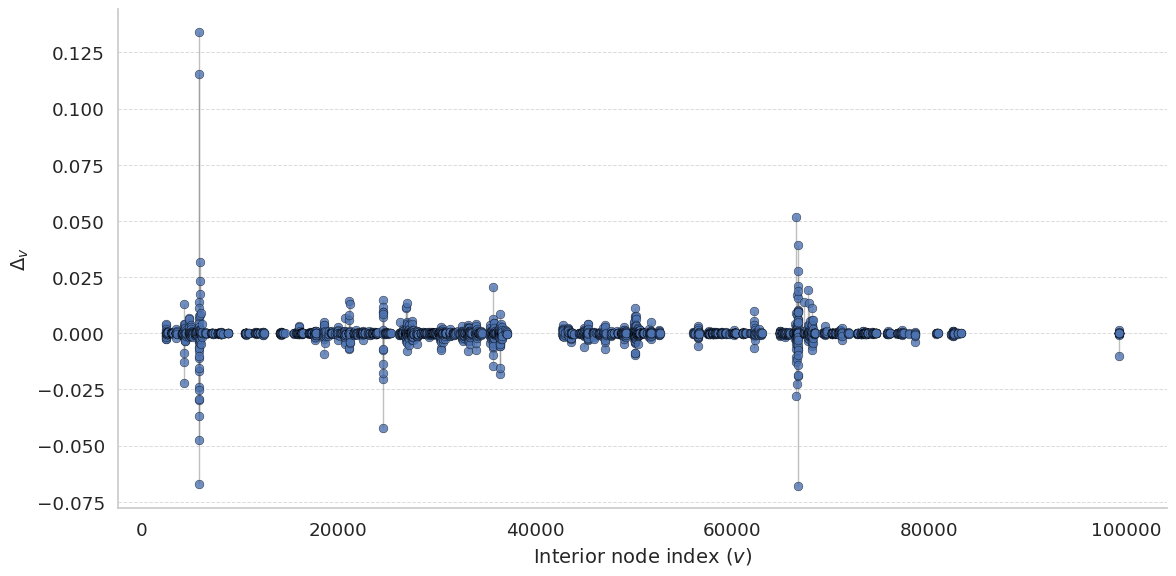

In [ ]:
# Set a clean style with larger font
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points colored by value with better aesthetics
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

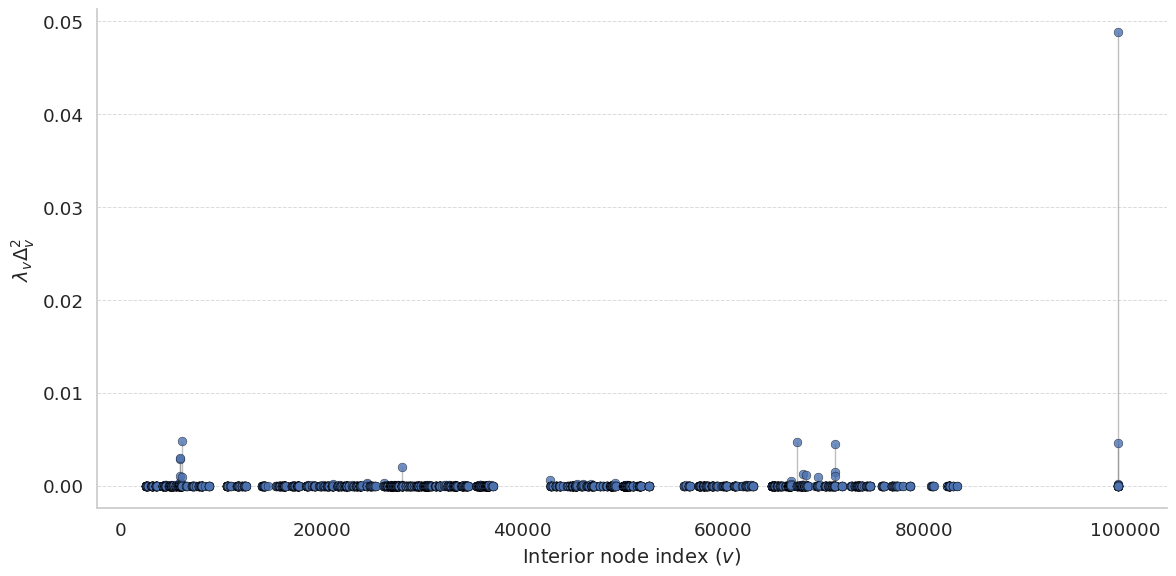

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points with subtle edge for clarity
scatter = ax.scatter(
    dh_indices[:-1],
    dh_coords[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=dh_indices,
    ymin=0,
    ymax=dh_coords,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

### Compute level of significance

#### Random topology CDF

In [ ]:
N = 10

nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[nodes]
subtree_starts = tree.find_subtree_start_indices()[nodes]

sort_idx = np.argsort(dh_coords[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords[sort_idx]
ordered_dh_indices = dh_indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]

print(f"{'Index':>10} {'Subtree Size':>14} {'Coord.':>10} {'P-Value':>10}")
print("-" * 48)

for idx in range(N):
    start = ordered_subtree_starts[idx]
    width = ordered_subtree_sizes[idx]
    func = diff[start:start + width].toarray().reshape(-1)
    cdf_val = pcms.haar.cdf_proj_cbst(
        ordered_dh_coords[idx], 
        f=func,
        eps=0.005,
        delta=0.001
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    print(f"{ordered_indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_coords[idx]:>10.4f} {pval:>10.3e}")

     Index   Subtree Size     Coord.    P-Value
------------------------------------------------
     99311          95297    -0.0102  1.969e-05
      6079           1792     0.0092  1.248e-01
     67317            835     0.0139  1.100e-01
     99307          50035     0.0014  1.316e-03
     71160          14472    -0.0029  5.408e-03
      5923            600     0.0173  4.122e-01
      5921            240     0.0319  6.545e-01
     27998          20765    -0.0015  6.091e-03
     71159           4899     0.0024  1.719e-01
     67959           1477     0.0057  3.740e-01


#### Difference of Dirichlet CDF

In [ ]:
start = time.time()
pvals_dod = np.zeros(coords.data.shape)
for i_idx, j_idx in enumerate(tree.find_interior_nodes()[coords.indices]):
    children = tree.find_children(j_idx)
    if children.size == 1:
        pvals_dod[i_idx] = 1.0
    else:
        cdf_val = pcms.haar.cdf_proj_dirichlet_diff(
            coords.data[i_idx], 
            tree=tree,
            node=j_idx,
            eps=0.01,
            delta=0.01
        )
        pvals_dod[i_idx] = 2 * min(cdf_val, 1 - cdf_val)
print("Elapsed time: ", time.time() - start)

Elapsed time:  19.840406894683838


In [ ]:
alpha = 0.05
do_reject_dod = pvals_dod < alpha

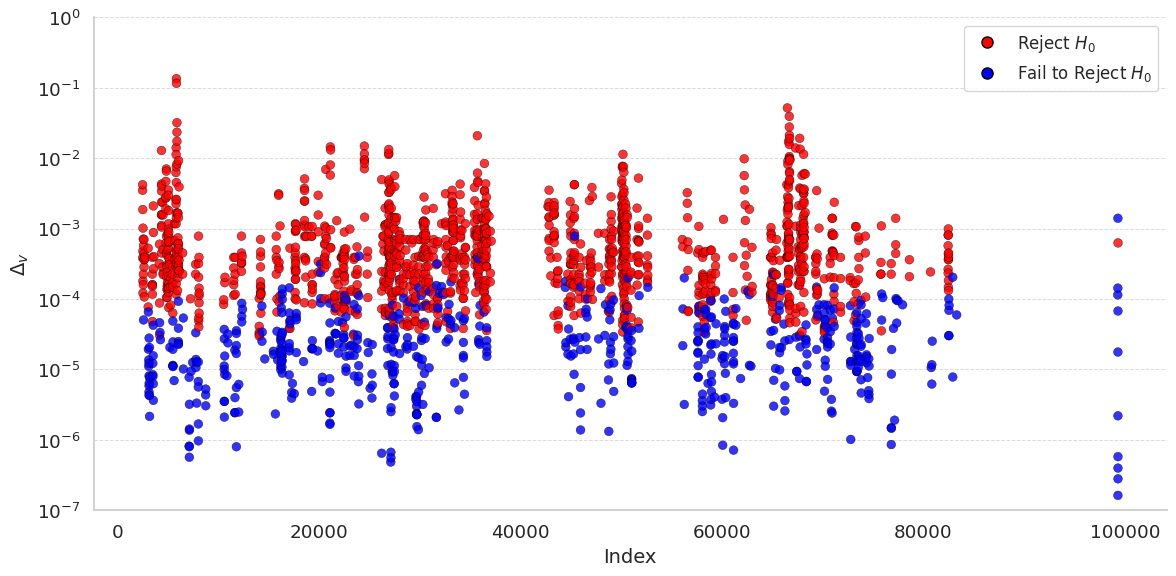

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter with edge and higher zorder
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Use log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-7, 1])

# Custom legend with clearer labels and markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Axis labels
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel(r'$\Delta_{v}$', fontsize=14)

# Add y-axis grid only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove clutter
sns.despine()

plt.tight_layout()
plt.show()

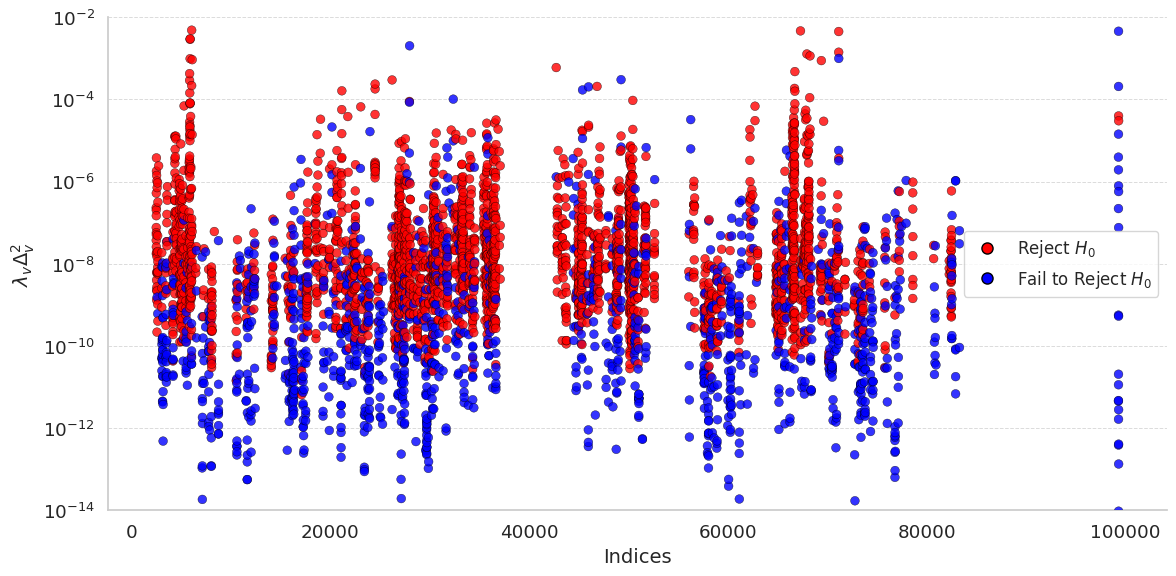

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to binary colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    dh_indices[:-1],
    dh_coords[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e-2])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [ ]:
N = 10

nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[nodes]
subtree_starts = tree.find_subtree_start_indices()[nodes]

sort_idx = np.argsort(dh_coords[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords[sort_idx]
ordered_dh_indices = dh_indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]
ordered_nodes = nodes[sort_idx]

print(f"{'Index':>10} {'Subtree Size':>14} {'Coord.':>10} {'P-Value':>12}")
print("-" * 50)

for idx in range(N):
    cdf_val = pcms.haar.cdf_proj_dirichlet_diff(
        ordered_coords[idx], 
        tree=tree,
        node=ordered_nodes[idx],
        eps=0.0005,
        delta=0.0001
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    print(f"{ordered_dh_indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>12.3e}")

     Index   Subtree Size     Coord.      P-Value
--------------------------------------------------
     99311          95297     0.0488    0.000e+00
      6079           1792     0.0048    0.000e+00
     67317            835     0.0047    0.000e+00
     99307          50035     0.0046    3.757e-01
     71160          14472     0.0045    3.703e-04
      5923            600     0.0030    0.000e+00
      5921            240     0.0029    0.000e+00
     27998          20765     0.0020    1.407e-01
     71159           4899     0.0014    5.049e-07
     67959           1477     0.0013    0.000e+00


In [ ]:
idx = 0
cdf_val = pcms.haar.cdf_proj_dirichlet_diff(
    ordered_coords[idx], 
    tree=tree,
    node=ordered_nodes[idx],
    eps=0.0005,
    delta=0.001
)
pval = 2 * min(cdf_val, 1 - cdf_val)
print(f"{ordered_dh_indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>12.3e}")

     99311          95297     0.0488    0.000e+00
